# 증상추출 모델 - 증상정보 입력 시 증상명 추출

# 관련 모듈 설치 및 환경 설정

In [2]:
 konlpy 설치를 위해 자바홈 설정
import os
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk-17'  # 설치 경로에 맞게 수정

In [4]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 40.3 MB/s eta 0:00:00


# 모듈 임포트

In [4]:
import pandas as pd
from konlpy.tag import Kkma
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 모델 제작

In [3]:
# Kkma 인스턴스 초기화
kkma = Kkma()

# CSV 파일을 읽어 데이터프레임으로 생성
# 데이터 미제공 
data1 = pd.read_csv('./../../Data/symptom_describe_new_final.csv')
data1.rename(columns={'symptom_describe_new': 'symptom_describe'}, inplace=True)
data2 = pd.read_csv('./../../Data/symptom_description240516.csv')

# 두 데이터프레임을 연결
data = pd.concat([data1, data2])

# 결측치 제거 및 중복 제거
data = data.dropna()
data = data.drop_duplicates(subset=['symptom_describe'])

# 인덱스 재설정
data.reset_index(drop=True, inplace=True)

# 증상 설명을 형태소 분석하여 리스트에 저장하는 함수
def process_descriptions(descriptions):
    tokenized_symptoms = []
    for description in descriptions:
        if isinstance(description, str):
            try:
                tokens = kkma.morphs(description)
                tokenized_symptoms.append(" ".join(tokens))
            except Exception as e:
                print(f"Error processing description '{description}': {e}")
        else:
            print(f"Skipping non-string input: {description}")
    return tokenized_symptoms

# 'symptom_describe' 열에서 설명을 추출하여 형태소 분석 수행
symptom_descriptions = data['symptom_describe'].tolist()
tokenized_symptoms = process_descriptions(symptom_descriptions)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tokenized_symptoms)

# 입력 값 처리
input_value_raw = "두통, 체중이 감소함"
input_values = input_value_raw.split(",")

# selected_symptoms_info 리스트 초기화: 선택된 증상 정보를 저장합니다.
selected_symptoms_info = []

# selected_symptoms_id_set 집합 초기화: 선택된 증상의 ID를 저장하여 중복을 방지합니다.
selected_symptoms_id_set = set()

# 형태소 분석을 통해 입력 값을 토큰화
input_tokenized = [" ".join(kkma.morphs(input_value)) for input_value in input_values]

for input_value, input_tok in zip(input_values, input_tokenized):
    for index, row in data.iterrows():
        symptom = row['symptoms']
        if symptom in input_value:
            # symptoms이 완전히 일치하는 경우에 대해 처리
            if row['symptom_ids'] not in selected_symptoms_id_set:
                selected_symptoms_info.append((symptom, 1.0, row['symptom_ids'], row['symptom_describe']))
                selected_symptoms_id_set.add(row['symptom_ids'])

    # 타겟 문장의 TF-IDF 벡터화
    target_vector = vectorizer.transform([input_tok])

    # 증상과 타겟 문장 간의 유사도 계산
    similarities = cosine_similarity(target_vector, tfidf_matrix)

    # 유사도를 리스트로 변환
    similarity_list = similarities.flatten()

    # 유사도 기반으로 상위 10개의 증상 선택
    top_indices = similarity_list.argsort()[-10:][::-1]  # 상위 10개의 인덱스를 유사도 기준으로 내림차순 정렬
    for idx in top_indices:
        if similarity_list[idx] > 0:  # 유사도가 0보다 큰 경우만 처리
            symptom = data.loc[idx, 'symptoms']
            if data.loc[idx, 'symptom_ids'] not in selected_symptoms_id_set:
                selected_symptoms_info.append((symptom, similarity_list[idx], data.loc[idx, 'symptom_ids'], data.loc[idx, 'symptom_describe']))
                selected_symptoms_id_set.add(data.loc[idx, 'symptom_ids'])

# 결과 출력
print(selected_symptoms_info)

[('두통', 1.0, 'SS000284', '머리에서 느껴지는 통증\n'), ('편두통', 0.5356585145301512, 'SS000333', '한쪽 머리에서만 느껴지는 두통\n'), ('뇌염증상', 0.3300524261211242, 'SS000281', '어떤 원인에 의해 두통, 발열, 오한, 구토, 의식 저하, 경련 등의 증상을 보이는 상태\n'), ('수막자극증상', 0.29460153914916865, 'SS000299', '뇌를 둘러싸고 있는 막 중 지주막하 공간에 염증이 생긴 경우 나타나는 두통, 열, 구토, 목 부위 경직, 실신 등의 증상\n'), ('뇌압상승증상', 0.26282014179955987, 'SS000280', '외상이나 종양,염증 등의 건강문제로 인하여 뇌의 부피가 커지면서 압력이 증가하여 두통, 구토, 오심, 의식장애 등의 증상이 나타나는 상태\n'), ('체중 감소', 1.0, 'SS001006', '체중이 감소함'), ('체중감소', 0.6042799315855443, 'SS000712', '체중이 줄어듦\n'), ('체중증가', 0.559316715278363, 'SS000713', '체중이 늘어남\n'), ('태아 저체중', 0.5027191289773377, 'SS000039', '저태아 출생 체중'), ('생리량 감소', 0.3117919417438454, 'SS000455', '월경량 감소'), ('양수의 감소', 0.2953190557982141, 'SS000414', '양수 감소'), ('심음 감소', 0.28414123611004294, 'SS000888', '심장 소리 감소'), ('체모감소', 0.2832082513780571, 'SS000835', '체모 감소')]


# 시각화

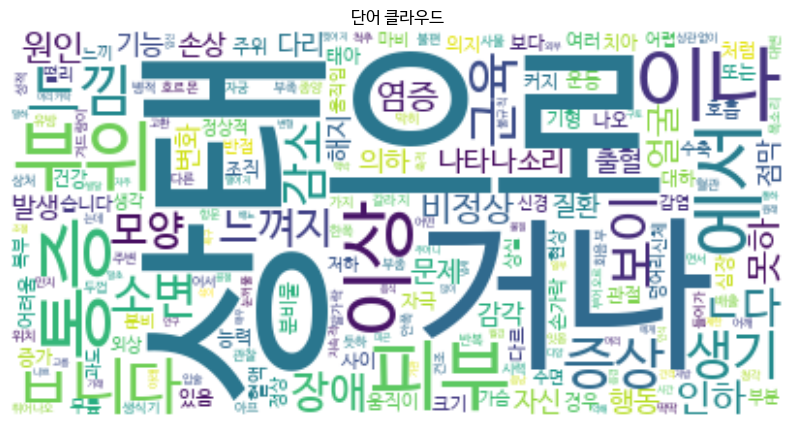

In [5]:
from wordcloud import WordCloud

# TF-IDF 행렬에서 단어 빈도를 추출하여 단어 클라우드를 생성합니다.
word_freq = tfidf_matrix.sum(axis=0).tolist()[0]
words = vectorizer.get_feature_names_out()
word_freq_dict = dict(zip(words, word_freq))

# 단어 클라우드 생성
wordcloud = WordCloud(font_path='NanumBarunGothic', background_color='white').generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('단어 클라우드')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


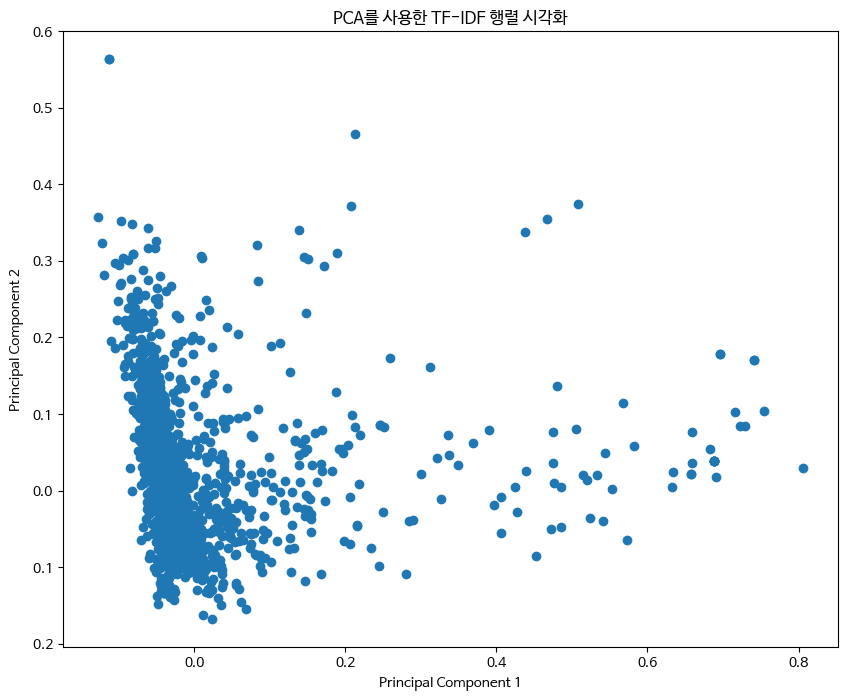

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TF-IDF 행렬을 PCA 또는 t-SNE를 사용하여 2차원으로 축소합니다.
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA를 사용한 TF-IDF 행렬 시각화')
plt.show()


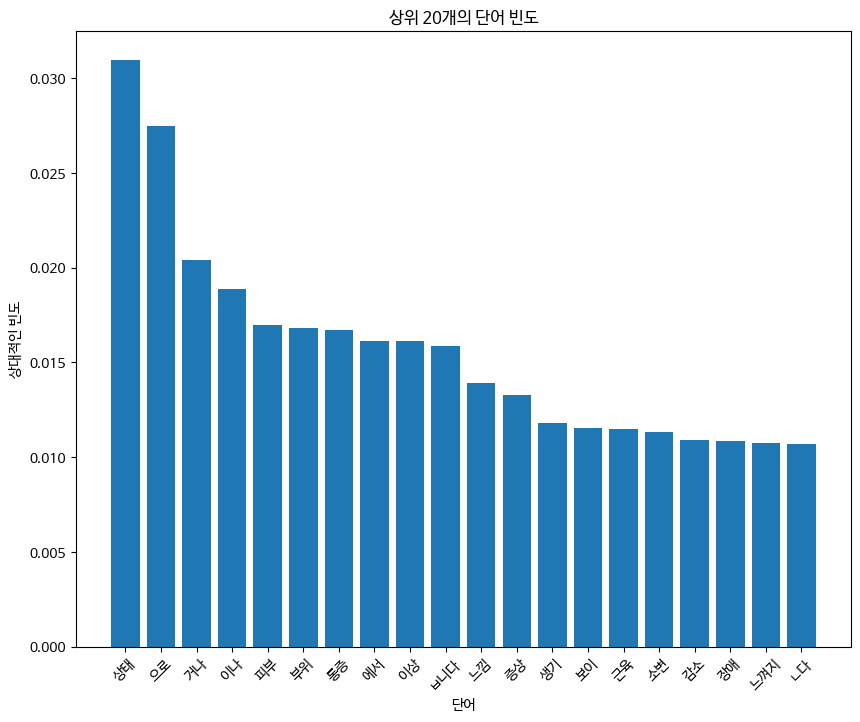

In [7]:
# TF-IDF 행렬의 단어별 가중치를 평균하여 단어의 상대적인 빈도를 계산합니다.
word_freq_mean = tfidf_matrix.mean(axis=0).tolist()[0]
word_freq_dict = dict(zip(words, word_freq_mean))

# 상위 n개의 단어를 선택합니다.
n = 20
top_n_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:n]
words = [word[0] for word in top_n_words]
freqs = [word[1] for word in top_n_words]

# 시각화
plt.figure(figsize=(10, 8))
plt.bar(words, freqs)
plt.xlabel('단어')
plt.ylabel('상대적인 빈도')
plt.title('상위 {}개의 단어 빈도'.format(n))
plt.xticks(rotation=45)
plt.show()

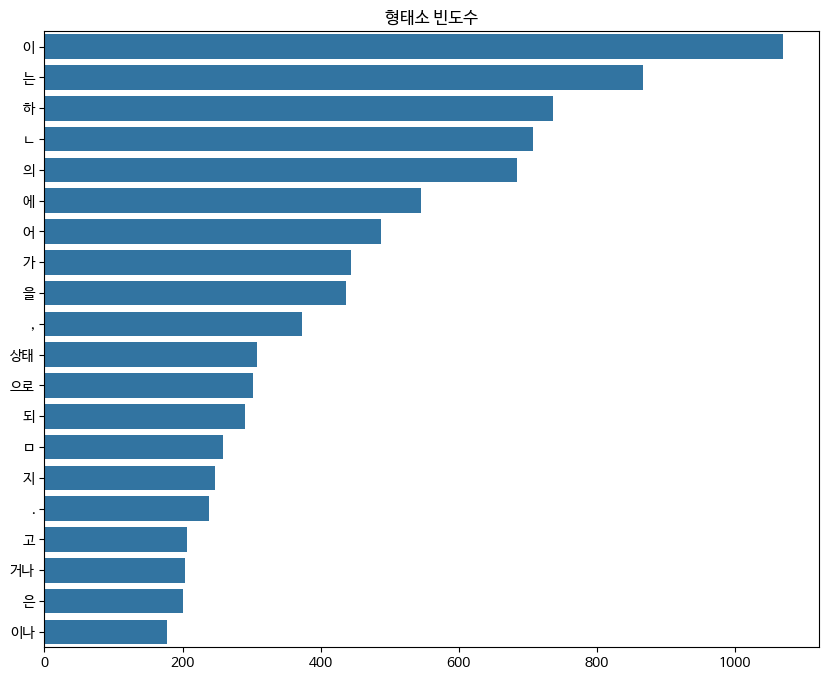

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 모든 형태소를 하나의 리스트로 합치기
all_tokens = sum([description.split() for description in tokenized_symptoms], [])

# 형태소별 빈도수 계산
counter = Counter(all_tokens)
most_common = counter.most_common(20) # 상위 20개 형태소 추출

# 형태소와 빈도수를 분리하여 리스트로 저장
words, freqs = zip(*most_common)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=list(freqs), y=list(words))
plt.title('형태소 빈도수')
plt.show()


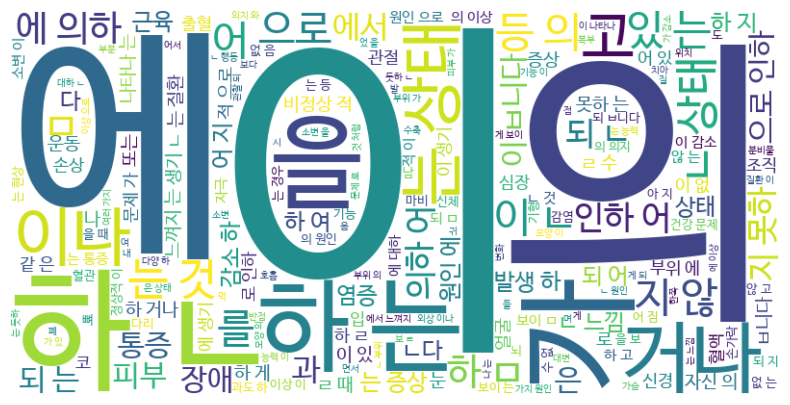

In [11]:
from wordcloud import WordCloud

# 형태소를 공백으로 연결하여 하나의 긴 텍스트로 만듦
all_text = ' '.join(all_tokens)

# 워드 클라우드 생성 및 시각화
wordcloud = WordCloud(font_path='NanumBarunGothic', background_color='white', width=800, height=400).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


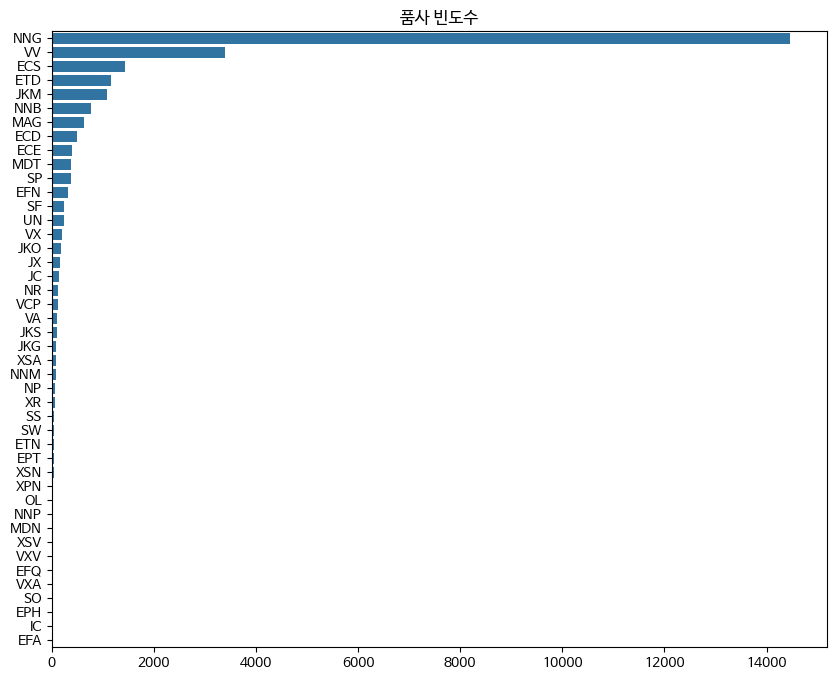

In [13]:

# 품사 태깅 수행
pos_tags = [kkma.pos(description) for description in tokenized_symptoms]

# 모든 품사 태그를 하나의 리스트로 합치기
all_tags = sum(pos_tags, [])
# 품사만 추출
tags_only = [tag for word, tag in all_tags]

# 품사별 빈도수 계산 및 시각화
tag_counter = Counter(tags_only)
tags, counts = zip(*tag_counter.most_common())

plt.figure(figsize=(10, 8))
sns.barplot(x=list(counts), y=list(tags))
plt.title('품사 빈도수')
plt.show()

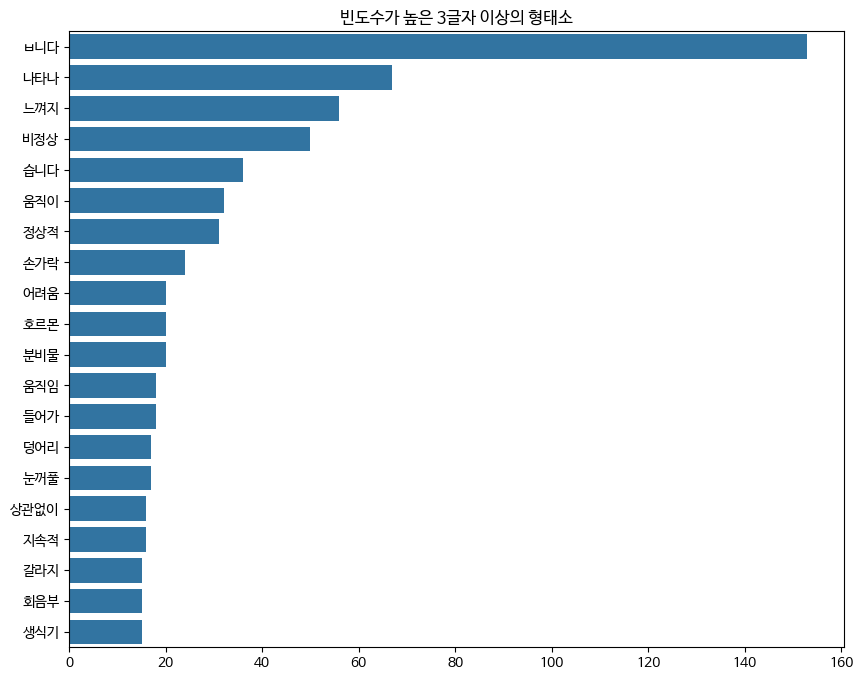

In [15]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all morphemes into a single list
all_tokens = sum([description.split() for description in tokenized_symptoms], [])

# Filter morphemes to include only those with 2 or more characters
filtered_tokens = [token for token in all_tokens if len(token) >= 3]

# Calculate the frequency of each morpheme
counter = Counter(filtered_tokens)
most_common = counter.most_common(20) # Extract the top 20 morphemes

# Separate the morphemes and frequencies into separate lists
words, freqs = zip(*most_common)

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x=list(freqs), y=list(words))
plt.title('빈도수가 높은 3글자 이상의 형태소')
plt.show()

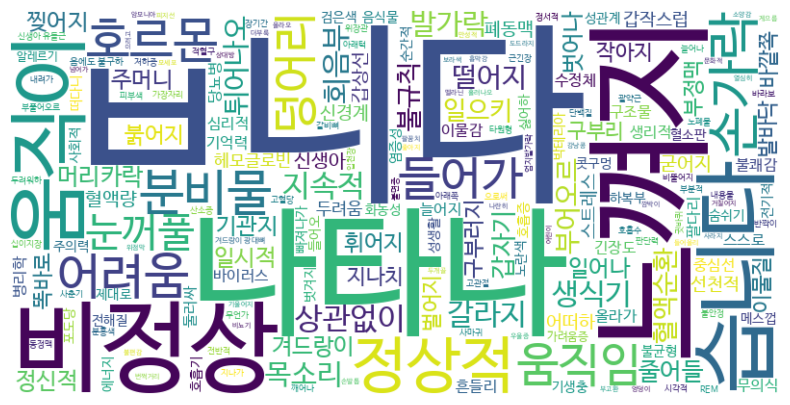

In [16]:
from wordcloud import WordCloud

# Filter morphemes to include only those with 2 or more characters
filtered_text = ' '.join(filtered_tokens)

# Generate and visualize the word cloud
wordcloud = WordCloud(font_path='NanumBarunGothic', background_color='white', width=800, height=400).generate(filtered_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()